<a href="https://colab.research.google.com/github/whtan88/RandomDataAnalyst_DataAnalysis/blob/main/Sentiment_Analysis_SG2025_GE_rally_speeches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The aim of this notebook is to perform some basic data and sentiment analysis of the 2025 Singapore General Election Candidate's rally english speeches. Data for 3 political parties are extracted, the PAP, WP and PSP based on rally transcript speeches from YouTube. The raw data is prepared on a best effort basis.

*** Note that the transcript from YouTube may not reflect the exact words that are spoken by the candidates and there may be errors in the transcript.

# Import libraries
We will import and load the libraries necessary. We will need langdetect to detect the langauge of the transcript to filter for only english and textblob to perform sentiment analysis.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install langdetect
from langdetect import detect
from langdetect import DetectorFactory, LangDetectException

import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=665dc3d3d3d85b518f391dd6f0fd27e72222b2f0da83b2c35a69723373daab81
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


We can test to see that each column value will be given a polarity score, and the total polarity score of the speech is aggregated and the average of the scores is output as the score for the sentence. Below, we can see that the results of the 2 are the same.

In [7]:
d = {'Party': ['P1', 'P1', 'P1', 'P1', 'P1', 'P2', 'P2'],
     'Candidate': ['P1C1', 'P1C1', 'P1C1', 'P1C2', 'P1C2', 'P2C1', 'P2C1'],
     'Speech': ['0.798', '0.0123', 'love', 'goodness and kindness', 'foreign speech hate', 'pip i feel truly privileged to stand before you once again as your candidate', 'for Ming UTGRC together with Prime Minister Lawrence Wong Mayor Alexam and Miss His']}

df = pd.DataFrame(d)

def sentiment_polarity(text):
  txtblob_speech = TextBlob(text)
  txt_polarity = txtblob_speech.sentiment.polarity
  return txt_polarity

df['Polarity_Score'] = df['Speech'].apply(sentiment_polarity)
print(sum(df['Polarity_Score']))

df_1 = df.groupby(['Candidate'])['Speech'].agg(' '.join).reset_index()
df_1['Polarity_Score'] = df_1['Speech'].apply(sentiment_polarity)
print(sum(df_1['Polarity_Score']))

0.03749999999999998
0.03749999999999998


# Preprocessing the Data

Before performing Sentiment Analysis, we will perform the following preprocessing steps:

- Remove non speech english words such as [Applause]

- Only include english language parts of the speeches

For Sentiment Analysis, we can use the below as a gauge:

Polarity Score:

-1 : Negative

0 : Neutral

1 : Positive

Subjectivity Score:

-1 : Objective

1 : Subjective

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/whtan88/DataSet/main/sg_ge_2025_rally_speech.csv')

df_results = pd.read_csv('https://raw.githubusercontent.com/whtan88/DataSet/main/sg_ge_2025_election_results.csv')

# Include a category by GRC or SMC
def check_district(row):
  return row['District'][-3:]

df['GRC_SMC'] = df.apply(check_district,axis=1)

# Removing non speech english parts such as Applause and Music
df['Speech'] = df['Speech'].str.replace('\[Applause\]|\[Music\]|\[Laughter\]|foreign speech|fore speech', '', regex=True)
df = df[df['Speech'] != ''].copy()

# Removing non English speech parts
DetectorFactory.seed = 8
def detect_language(text):
  try:
    txt_lang = detect(text)
  except LangDetectException:
    txt_lang = 'unknown' # Assign 'unknown' if language detection fails
  return txt_lang

# Detecting and filtering for english language speech
df = df[df['Speech'] != ''].copy()
df['language'] = df['Speech'].apply(detect_language)
df = df[df['language'] == 'en']

# Joining the candidate speech
df_1 = df.groupby(['Party','District','GRC_SMC','Candidate'])['Speech'].agg(' '.join).reset_index()

# Extracting sentiment analysis from the speech
def sentiment_polarity(text):
  txtblob_speech = TextBlob(text)
  txt_polarity = txtblob_speech.sentiment.polarity
  return txt_polarity

def sentiment_subjectivity(text):
  txtblob_speech = TextBlob(text)
  txt_subjectivity = txtblob_speech.sentiment.subjectivity
  return txt_subjectivity

def sentiment_assessments(text):
  txtblob_speech = TextBlob(text)
  txt_sentiment_assessments = txtblob_speech.sentiment_assessments
  return txt_sentiment_assessments

def polarity_indicator(score):
  if score < 0:
    return -1
  elif score == 0:
    return 0
  else:
    return 1

def subjectivity_indicator(score):
  if score < 0.5:
    return -1
  else:
    return 1

df_1['Polarity_Score'] = df_1['Speech'].apply(sentiment_polarity)
df_1['Subjectivity_Score'] = df_1['Speech'].apply(sentiment_subjectivity)
#df_1['Assessment'] = df_1['Speech'].apply(sentiment_assessments)
df_1['Polarity_indicator'] = df_1['Polarity_Score'].apply(polarity_indicator)
df_1['Subjectivity_indicator'] = df_1['Subjectivity_Score'].apply(subjectivity_indicator)

df_1.head()

,Party,District,GRC_SMC,Candidate,Speech,Polarity_Score,Subjectivity_Score,Polarity_indicator,Subjectivity_indicator
0,PAP,Aljunied GRC,GRC,Adrian Ang,very good to see all of you here today i think...,0.120810,0.423356,1,-1
1,PAP,Aljunied GRC,GRC,Chan Hui Yuh,friends of Alid before I start I just want to...,0.179365,0.544606,1,1
2,PAP,Aljunied GRC,GRC,Daniel Liu,okay my name is Daniel Leu you know as any can...,0.162719,0.421603,1,-1
3,PAP,Aljunied GRC,GRC,Faisal Abdul Aziz,residents of Aljunet good evening wait wait w...,0.205060,0.455744,1,-1
4,PAP,Aljunied GRC,GRC,Jagathishwaran Rajo,Rajo Good afternoon dear Singaporeans I stand ...,0.217615,0.492427,1,-1


In [4]:
# Check range of polarity and subjective scores
print(f'Min Polarity Score : {min(df_1["Polarity_Score"])}')
print(f'Max Polarity Score : {max(df_1["Polarity_Score"])}')
print(f'Min Subjective Score : {min(df_1["Subjectivity_Score"])}')
print(f'Max Subjective Score : {max(df_1["Subjectivity_Score"])}')

Min Polarity Score : 0.005555555555555564
Max Polarity Score : 0.30999999999999994
Min Subjective Score : 0.342860886492962
Max Subjective Score : 0.5856479518214209


In [5]:
# Most negative candidates
df_1.groupby(['Party','District','Candidate']).agg({'Polarity_Score' : 'mean', 'Subjectivity_Score' : 'mean',
                                        'Polarity_indicator': 'sum', 'Subjectivity_indicator' : 'sum'}).reset_index().sort_values('Polarity_Score').head(5)

,Party,District,Candidate,Polarity_Score,Subjectivity_Score,Polarity_indicator,Subjectivity_indicator
32,PAP,Marine Parade - Braddell Heights GRC,Muhammad Faishal Ibrahim,0.005556,0.500000,1,1
74,PAP,West Coast - Jurong West GRC,Shawn Huang,0.102464,0.491291,1,-1
29,PAP,Jurong East - Bukit Batok GRC,Murali Pillai,0.104286,0.438135,1,-1
58,PAP,Sembawang GRC,Ong Ye Kung,0.108246,0.433753,1,-1
90,WP,Punggol GRC,Alia Mattar,0.111554,0.382443,1,-1


In [6]:
# Most positive candidates
df_1.groupby(['Party','District','Candidate']).agg({'Polarity_Score' : 'mean', 'Subjectivity_Score' : 'mean',
                                        'Polarity_indicator': 'sum', 'Subjectivity_indicator' : 'sum'}).reset_index().sort_values('Polarity_Score', ascending = False).head(5)

,Party,District,Candidate,Polarity_Score,Subjectivity_Score,Polarity_indicator,Subjectivity_indicator
96,WP,Sengkang GRC,Louis Chua,0.310000,0.460000,1,-1
34,PAP,Marsiling - Yew Tee GRC,Hany Soh,0.285166,0.498463,1,-1
33,PAP,Marsiling - Yew Tee GRC,Alex Yam,0.278274,0.541295,1,1
26,PAP,Jurong Central SMC,Xie Yao Quan,0.263464,0.496642,1,-1
30,PAP,Jurong East - Bukit Batok GRC,Rahayu Mahzam,0.261906,0.493028,1,-1


In [9]:
# Most positive Districts
df_2 = df_1.groupby(['Party','District']).agg({'Polarity_Score' : 'mean', 'Subjectivity_Score' : 'mean',
                                        'Polarity_indicator': 'mean', 'Subjectivity_indicator' : 'mean'}).reset_index().sort_values('Polarity_Score', ascending = False)
df_2.head()

,Party,District,Polarity_Score,Subjectivity_Score,Polarity_indicator,Subjectivity_indicator
8,PAP,Jurong Central SMC,0.263464,0.496642,1.0,-1.0
3,PAP,Bukit Gombak SMC,0.249784,0.480965,1.0,-1.0
7,PAP,Jalan Kayu SMC,0.237065,0.493113,1.0,-1.0
18,PAP,Pioneer SMC,0.229698,0.458907,1.0,-1.0
5,PAP,Chua Chu Kang GRC,0.227773,0.444406,1.0,-1.0


<Axes: xlabel='Polarity_Score', ylabel='Count'>

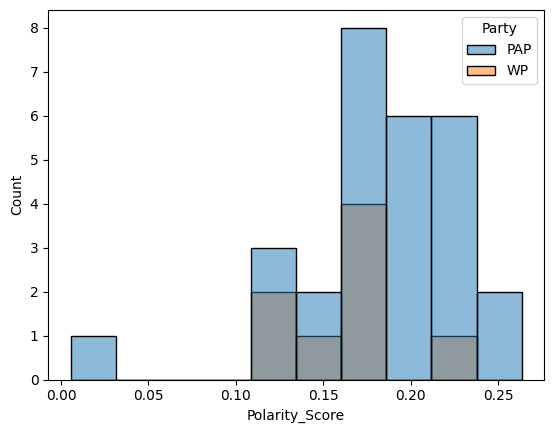

In [10]:
# Histogram plot of Polarity Score
sns.histplot(data = df_2, x = 'Polarity_Score', hue = 'Party')

<Axes: xlabel='Subjectivity_Score', ylabel='Count'>

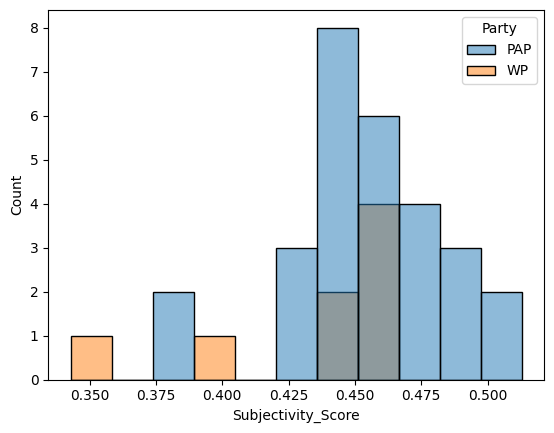

In [11]:
# Histogram plot of Subjectivity Score
sns.histplot(data = df_2, x = 'Subjectivity_Score', hue = 'Party')

In [17]:
# Combining dataframes to see the results against polarity and subjectivity scores
df_final = df_2.merge(df_results, left_on=['District','Party'], right_on=['District','Party'])
df_final.head()

,Party,District,Polarity_Score,Subjectivity_Score,Polarity_indicator,Subjectivity_indicator,Vote_percentage
0,PAP,Jurong Central SMC,0.263464,0.496642,1.0,-1.0,0.8051
1,PAP,Bukit Gombak SMC,0.249784,0.480965,1.0,-1.0,0.7583
2,PAP,Jalan Kayu SMC,0.237065,0.493113,1.0,-1.0,0.5147
3,PAP,Pioneer SMC,0.229698,0.458907,1.0,-1.0,0.6542
4,PAP,Chua Chu Kang GRC,0.227773,0.444406,1.0,-1.0,0.6359


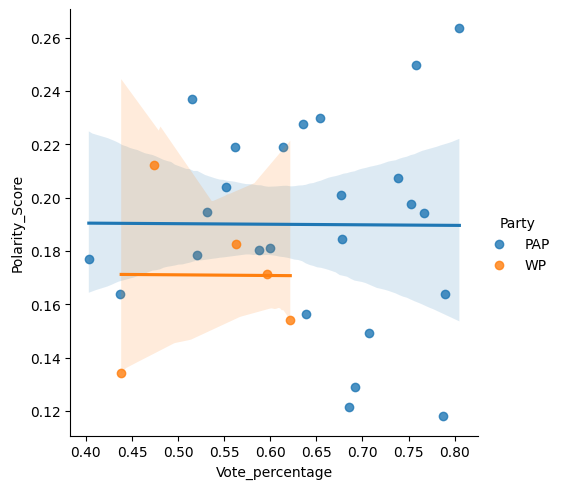

In [20]:
# Plot of Polarity Score against Vote Percentage
sns.lmplot(data=df_final, x="Vote_percentage", y="Polarity_Score", hue="Party")

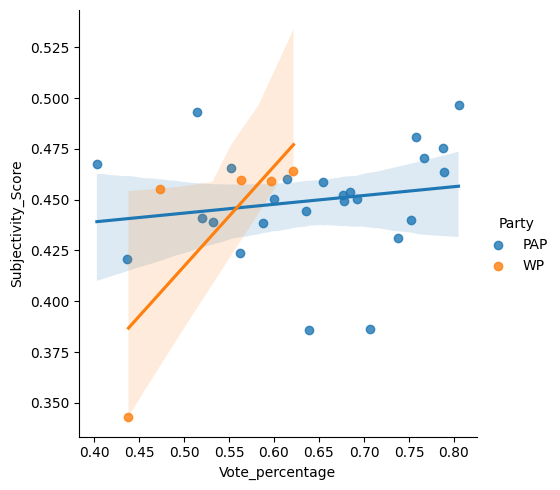

In [21]:
# Plot of Subjectivity Score against Vote Percentage
sns.lmplot(data=df_final, x="Vote_percentage", y="Subjectivity_Score", hue="Party")

# Word Cloud of PAP Speeches

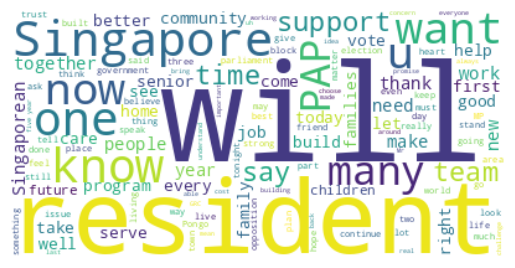

In [12]:
# Joining all candidate speeches by party
df_party = df.groupby(['Party'])['Speech'].agg(' '.join).reset_index()

# Create stopword list:
stopwords = set(STOPWORDS)

# Create and generate a word cloud image:
df_pap = df_party[df_party['Party'] == 'PAP'].copy()
text = df_pap['Speech'][0]
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Word Cloud of WP Speeches

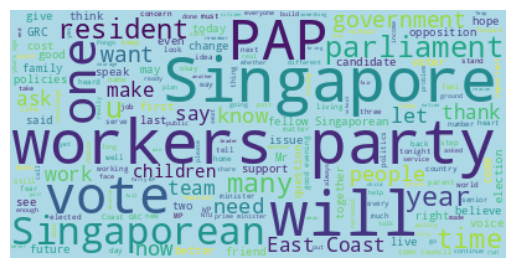

In [36]:
# Create and generate a word cloud image:
df_wp = df_party[df_party['Party'] == 'WP'].copy()
text = df_wp['Speech'].iloc[0]
wordcloud = WordCloud(stopwords=stopwords, background_color="lightblue").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Conclusion

From the data analysis above, it appears that for Singapore General Election of 2025, the polarity and subjectivity of the candidates speeches do not impact the vote percentages of the districts.